---
---

# **Audio Classification**

We will follow the below scheme

![image.png](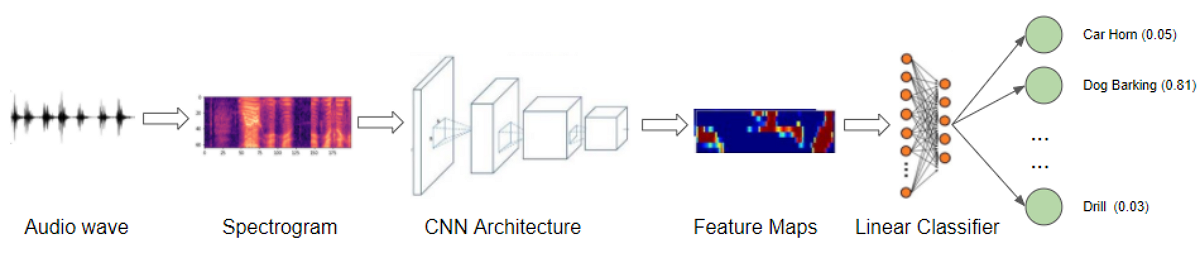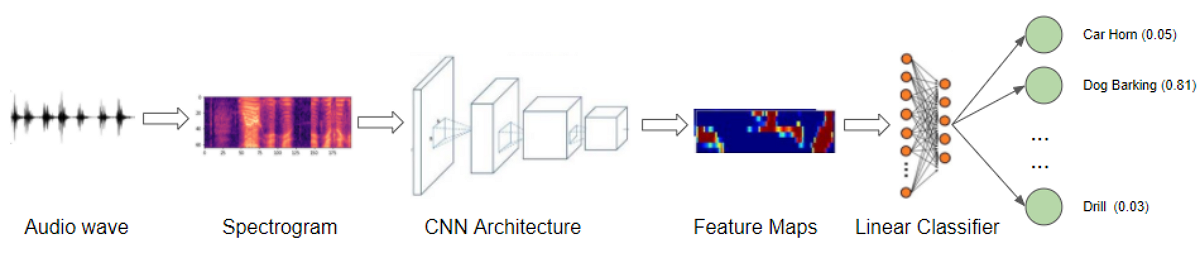)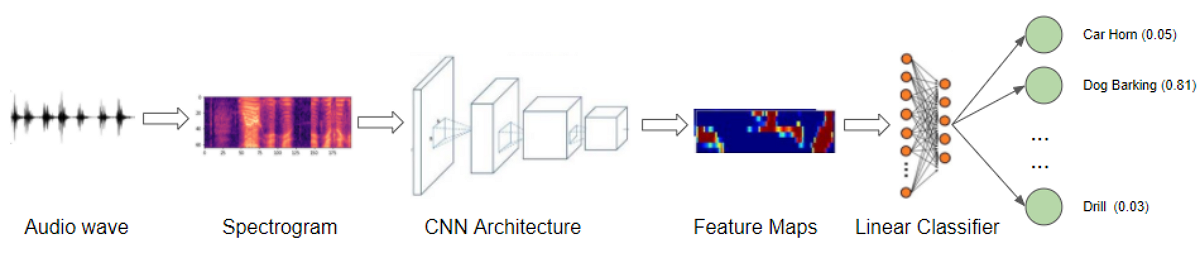

In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
!unzip dataset_audio.zip

In [ ]:
#!unzip dataset_audio.zip

---
---
# **Preprocessing**

In [ ]:
!pip install tensorflow_io
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt

from keras import initializers
from pydub import AudioSegment
from sklearn import preprocessing
from scipy.io.wavfile import read
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def delete_excess(data):
  return data[:length_audio]

def add_average(data):
  result = np.zeros(shape=(length_audio,))
  end = data.shape[0]
  mean = np.mean(data[end-25:])
  result[:end] = data
  result[end:] = mean
  return result

def plot_spectrogram(spectrogram, ax, title, rate):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  ax.set_xlim([0, rate])
  ax.set_title(title)

In [ ]:
directory = "./dataset_audio/"
file_name = "I0474.wav"
path = directory + file_name

rate, data = read(path)

length = data.shape[0] / rate   # 
length_audio = data.shape[0]    # 176400
nb_channels = data.shape[1]     # 2

n_samples = 0
for file_name in os.listdir(directory):
  n_samples += 1

dataset = np.zeros(shape=(n_samples, length_audio))

# creating the dataset and labels
labels = np.zeros(shape=(n_samples,))

for index, filename in enumerate(os.listdir(directory)):
  if filename[0] == 'I': labels[index] = 1
  path = directory + filename
  rate, data = read(path)
  data = np.mean(data,axis=1)
  dim = data.shape
  if dim != (length_audio, nb_channels):
    if dim[0] > length_audio:
      result = delete_excess(data)
    else:
      result = add_average(data)
    dataset[index] = result
  else:
    dataset[index] = data

dataset = (dataset - np.mean(dataset)) / np.std(dataset)  # let's normalize

print("----------------------------------")
print("| dataset.shape: ", dataset.shape)
print("| labels.shape : ", labels.shape)
print("----------------------------------")

----------------------------------
| dataset.shape:  (200, 176400)
| labels.shape :  (200,)
----------------------------------


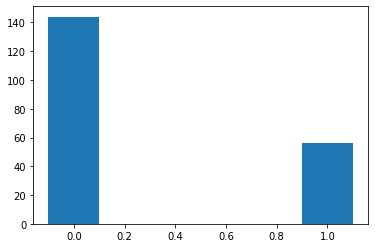

In [ ]:
# let's separate indor and outdoor data

args_indoor  = np.argwhere(labels==1)
args_outdoor = np.argwhere(labels==0)

dataset_indoor  = dataset[args_indoor].squeeze()
dataset_outdoor = dataset[args_outdoor].squeeze()

plt.bar([0,1], [dataset_outdoor.shape[0], dataset_indoor.shape[0]], width=0.2);

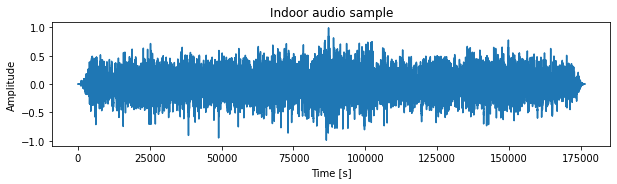

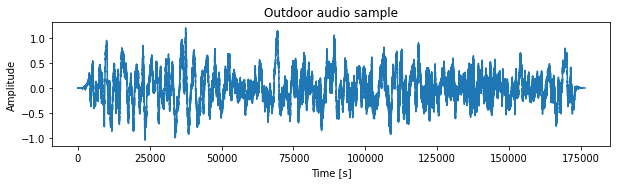

In [ ]:
timesteps = np.arange(dataset.shape[1])

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, dataset_indoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Indoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,2)
plt.plot(timesteps, dataset_outdoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Outdoor audio sample")
plt.show()

In [ ]:
# transformation to spectrogram

frame_length = 685
frame_step = int(frame_length/2)

spectrogram_indoor  = tf.abs(tf.signal.stft(signals=dataset_indoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))
spectrogram_outdoor = tf.abs(tf.signal.stft(signals=dataset_outdoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))

print("-----------------------------------------------")
print("|  dataset_indoor.shape:", dataset_indoor.shape)
print("|  spectrogram_indoor.shape:", spectrogram_indoor.shape)
print("-----------------------------------------------")
print("|  dataset_outdoor.shape:", dataset_outdoor.shape)
print("|  spectrogram_outdoor.shape:", spectrogram_outdoor.shape)
print("-----------------------------------------------")

-----------------------------------------------
|  dataset_indoor.shape: (56, 176400)
|  spectrogram_indoor.shape: (56, 514, 513)
-----------------------------------------------
|  dataset_outdoor.shape: (144, 176400)
|  spectrogram_outdoor.shape: (144, 514, 513)
-----------------------------------------------


In [ ]:
ipd.Audio(dataset_indoor[0,:], rate=rate)

In [ ]:
ipd.Audio(dataset_outdoor[0,:], rate=rate)

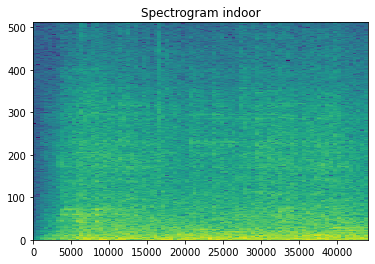

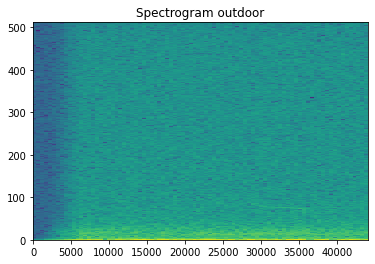

In [ ]:
fig, ax = plt.subplots()  
plot_spectrogram(spectrogram_indoor[0,:].numpy(), ax, 'Spectrogram indoor', rate)
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(spectrogram_outdoor[0,:].numpy(), ax, 'Spectrogram outdoor', rate)
plt.show()

In [ ]:
print("spectrogram_indoor.shape: ", spectrogram_indoor.shape)

spectrogram_indoor.shape:  (56, 514, 513)


In [ ]:
resize_shape = [200, 200]

spectrogram_indoor = np.expand_dims(spectrogram_indoor, axis=-1)
spectrogram_outdoor = np.expand_dims(spectrogram_outdoor, axis=-1)

spectrogram_indoor  = tf.image.resize(spectrogram_indoor , resize_shape, antialias=True).numpy().squeeze()
spectrogram_outdoor = tf.image.resize(spectrogram_outdoor, resize_shape, antialias=True).numpy().squeeze()

In [ ]:
print("-----------------------------------------------")
print("|  dataset_indoor.shape:", dataset_indoor.shape)
print("|  spectrogram_indoor.shape:", spectrogram_indoor.shape)
print("-----------------------------------------------")
print("|  dataset_outdoor.shape:", dataset_outdoor.shape)
print("|  spectrogram_outdoor.shape:", spectrogram_outdoor.shape)
print("-----------------------------------------------")

-----------------------------------------------
|  dataset_indoor.shape: (56, 176400)
|  spectrogram_indoor.shape: (56, 200, 200)
-----------------------------------------------
|  dataset_outdoor.shape: (144, 176400)
|  spectrogram_outdoor.shape: (144, 200, 200)
-----------------------------------------------


---
---
# **CGAN preparation**

**Model and function creation**

In [ ]:
def get_generator():

  # image dimension 200x200

  # label dimension (0 or 1)
  labels_dim = 1

  # latent space dimension
  latent_dim = 100

  ######################################################################################

  # Generator network
  _input_generator = layers.Input(shape=(latent_dim,))

  # Hidden layer 1
  _generator = (layers.Dense(1000))(_input_generator)
  _generator = (layers.LeakyReLU(alpha=0.2))(_generator)
  _generator = (layers.BatchNormalization(momentum=0.8))(_generator)
 
  # Hidden layer 2
  _generator = (layers.Dense(25*25*50))(_generator)

  # Output layer (before merging)
  _generator = (layers.Reshape((25, 25, 50)))(_generator)

  #######################################################################################

  # Labeling_generator
  #_input_label_generator = layers.Input(shape=(labels_dim,), dtype='int32')
  _input_label_generator = layers.Input(shape=(labels_dim,))

  # Hidden layer 1
  _label_generator = (layers.Dense(50))(_input_label_generator)
  _label_generator = (layers.LeakyReLU(alpha=0.2))(_label_generator)
  _label_generator = (layers.BatchNormalization(momentum=0.8))(_label_generator)

  # Hidden layer 2
  _label_generator = (layers.Dense(25*25*1))(_label_generator)

  # Output layer  (before merging)
  _label_generator = (layers.Reshape((25, 25, 1)))(_label_generator)

  ######################################################################################

  # Concatenation Layer
  generator = (layers.Concatenate()([_generator, _label_generator]))

  # Conv2DTranspose layer 1
  generator = (layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)

  # Conv2DTranspose layer 2
  generator = (layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)

  # Conv2DTranspose layer 3
  generator = (layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same'))(generator)
  generator = (layers.LeakyReLU(alpha=0.2))(generator)

  # Final output layer
  generator = (layers.Conv2D(1,(2, 2), activation='tanh', padding='same'))(generator)

  # Creating the model
  generator = tf.keras.Model(inputs=[_input_generator, _input_label_generator], outputs=generator)

  return generator

In [ ]:
def generator_loss(fake_output):
  
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def get_discriminator():

  # label dimension
  labels_dim = 1

  # prediction dimensions (class)
  results_dim = 1

  # image dimension 200x200
  image_dim = (200, 200, 1)

  ##############################################################################

  # Discriminator network, Image input
  _input_discriminator = layers.Input(shape=(image_dim))

  ##############################################################################

  # Labeling_discriminator
  _input_label_discriminator = layers.Input(shape=(labels_dim,), dtype='int32')

  # Hidden layer 1
  _label_discriminator = (layers.Dense(1000))(_input_label_discriminator)
  _label_discriminator = (layers.LeakyReLU(alpha=0.2))(_label_discriminator)
  _label_discriminator = (layers.BatchNormalization(momentum=0.8))(_label_discriminator)

  # Hidden layer 2
  _label_discriminator = (layers.Dense(200*200*1))(_label_discriminator)   # maybe batch-normalization here ?
  _label_discriminator = (layers.LeakyReLU(alpha=0.2))(_label_discriminator)
  _label_discriminator = (layers.BatchNormalization(momentum=0.8))(_label_discriminator)

  # Output layer  (before merging)
  _label_discriminator = (layers.Reshape((200, 200, 1)))(_label_discriminator)

  ##############################################################################

  # Merging Layer
  discriminator = (layers.Concatenate()([_input_discriminator, _label_discriminator]))

  # Conv2D layer 1
  discriminator = (layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Conv2D layer 2
  discriminator = (layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Conv2D layer 3
  discriminator = (layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Conv2D layer 4
  discriminator = (layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Conv2D layer 5
  discriminator = (layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)

  # Flatten layer
  discriminator = (layers.Flatten())(discriminator)

  # Dense layer 1
  discriminator = (layers.Dense(5000))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)
  discriminator = (layers.BatchNormalization(momentum=0.8))(discriminator)

  # Dense layer 2
  discriminator = (layers.Dense(1000))(discriminator)
  discriminator = (layers.LeakyReLU(alpha=0.2))(discriminator)
  discriminator = (layers.BatchNormalization(momentum=0.8))(discriminator)

  # Output layer
  discriminator = (layers.Dense(results_dim, activation='sigmoid'))(discriminator)

  # Creating the model
  discriminator = tf.keras.Model(inputs=[_input_discriminator, _input_label_discriminator], outputs=discriminator)

  return discriminator

In [ ]:
def discriminator_loss(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

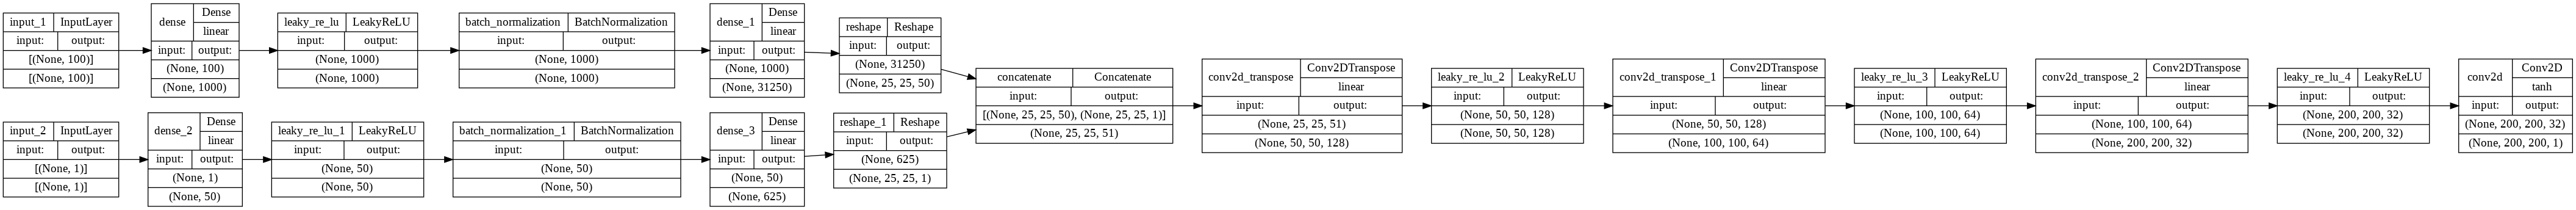

In [ ]:
# building the generator
generator = get_generator()

tf.keras.utils.plot_model(generator, to_file="generator.png", show_shapes=True, show_layer_activations=True, rankdir='LR')

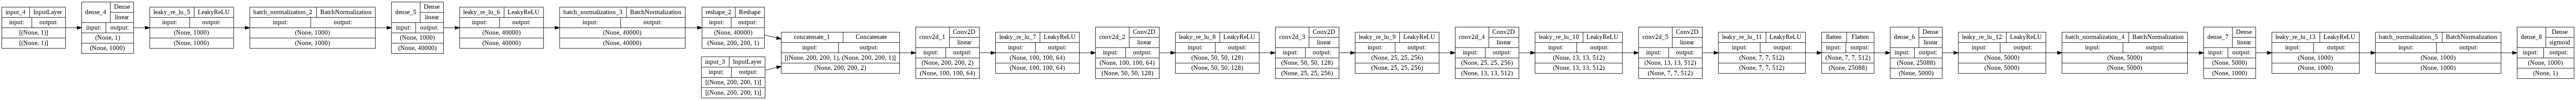

In [ ]:
# building the discriminator
discriminator = get_discriminator()

tf.keras.utils.plot_model(discriminator, to_file="discriminator.png", show_shapes=True, show_layer_activations=True, rankdir='LR')

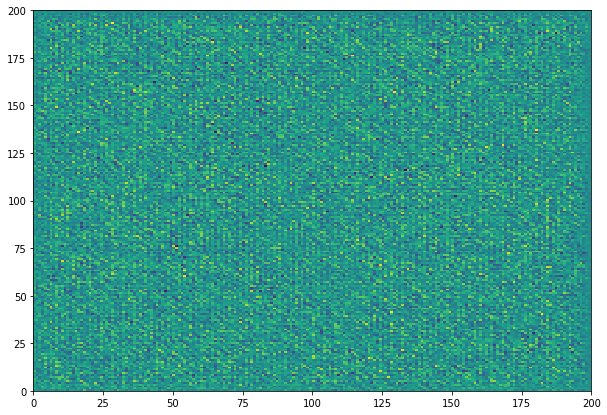

In [ ]:
# try the generator
latent_dim = 100

noise = tf.random.normal([1, latent_dim])
label = np.random.randint(0, 2, (1,))
seed = ([noise, label])

generated_spectrogram = generator(seed, training=False)

fig = plt.figure(figsize=(10, 7))
plt.pcolormesh(generated_spectrogram[0,:,:,0]);

In [ ]:
# generator summary

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1000)         101000      ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 50)           100         ['input_2[0][0]']                
                                                                                              

In [ ]:
# try the discriminator
seed = ([generated_spectrogram, label])

answer = discriminator(seed, training=False)
print("discriminator's aswer: ", answer)

discriminator's aswer:  tf.Tensor([[0.49995047]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 1000)         2000        ['input_4[0][0]']                
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 1000)         0           ['dense_4[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 1000)        4000        ['leaky_re_lu_5[0][0]']          
 rmalization)                                                                               

**Training functions**

In [ ]:
def generate_loss_plot(history):
  
  fig = plt.figure(figsize=(20, 7))
  plt.plot(history[0,:], label="Generator Loss")
  plt.plot(history[1,:], label="Discriminator Loss")
  plt.legend()
  plt.xlabel("Batches")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
def generate_plot(generator, epoch):

  n_classes = 2

  noise = tf.random.normal([1, LATENT_DIM])
  label_outdoor = np.zeros(shape=(1,))
  label_indoor  = np.ones(shape=(1,))

  # first class
  seed = ([noise, label_outdoor])
  generated_spectrogram_outdoor = generator(seed, training=False)

  fig, ax = plt.subplots()
  plt.pcolormesh(generated_spectrogram_outdoor[0,:,:,0])
  plt.show()

  # second class
  seed = ([noise, label_indoor])
  generated_spectrogram_indoor = generator(seed, training=False)

  fig, ax = plt.subplots()  
  plt.pcolormesh(generated_spectrogram_indoor[0,:,:,0])
  plt.show()

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

In [ ]:
@tf.function
def train_step(spects, labels):

    noises = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    labels_fake = np.random.randint(2, size=(BATCH_SIZE,))
    print(labels_fake)
    gen_seed=([noises, labels_fake])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_spects = generator(gen_seed, training=True)

      real_output = discriminator( ([spects          , labels])        , training=True)
      fake_output = discriminator( ([generated_spects, labels_fake])   , training=True)

      gen_loss  = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      losses = (gen_loss, disc_loss)

    gradients_of_generator      = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator  = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return losses

In [ ]:
def train(batched_data, epochs, epochs_plot=False, history_plot=False):

  history = np.empty(shape=(2,0))

  for epoch in range(epochs):
    start = time.time()

    for batched_audios, batched_labels in batched_data:

      losses = train_step(batched_audios, batched_labels)
      losses = np.array([losses[0].numpy(), losses[1].numpy()]).reshape((2,1))
      history = np.append(history, losses, axis=1)

    #display.clear_output(wait=True)
    if epochs_plot: generate_plot(generator, epoch + 1)
    if history_plot: generate_loss_plot(history)

    if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)
      if epochs_plot: generate_plot(generator, epoch + 1)
      generate_loss_plot(history)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #display.clear_output(wait=True)
  generate_plot(generator, epochs)
  generate_loss_plot(history)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer       = Adam(2e-4)
discriminator_optimizer   = Adam(2e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
---

# **CGAN execution**

In [ ]:
BATCH_SIZE  = 10
BUFFER_SIZE = 200
LATENT_DIM  = 100
epochs      = 100

labels = np.zeros(shape=(n_samples,))
labels[:spectrogram_indoor.shape[0]] = 1

dataset = np.concatenate((spectrogram_indoor, spectrogram_outdoor), axis=0)

batched_dataset = tf.data.Dataset.from_tensor_slices((dataset, labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(batched_dataset, epochs, epochs_plot=False, history_plot=False)

Time for epoch 1 is 3.131793737411499 sec


KeyboardInterrupt: ignored

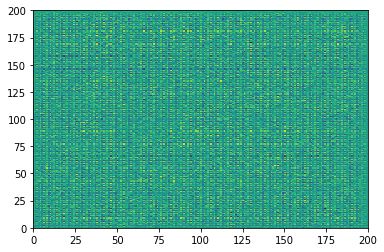

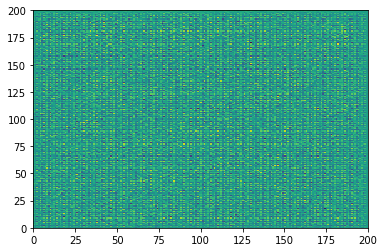

<Figure size 432x288 with 0 Axes>

In [ ]:
generate_plot(generator, epochs)

---
---
# **Model Building**

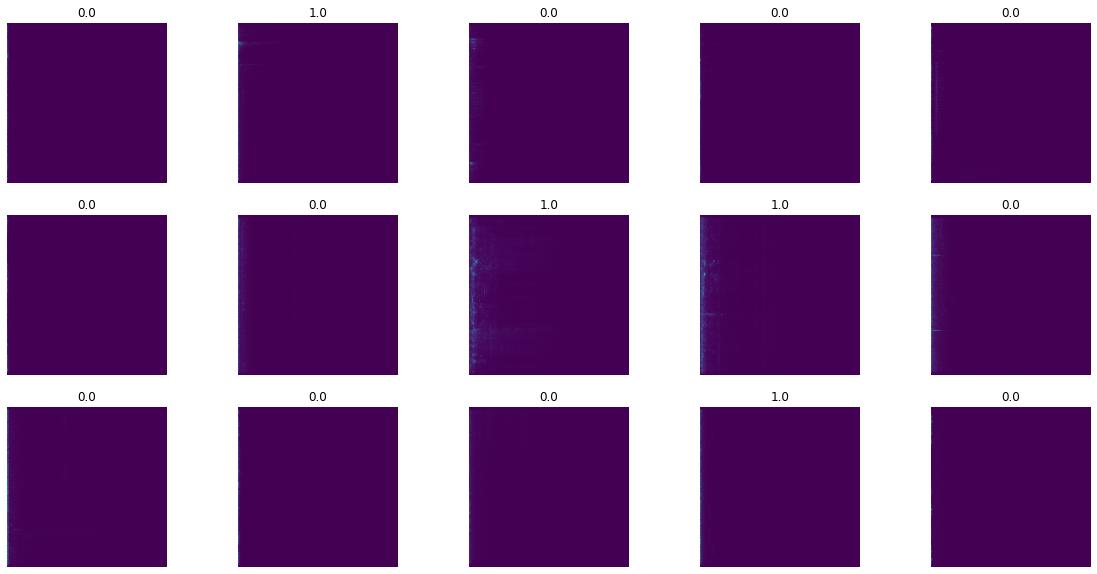

In [ ]:
# dataset creation

BATCH_SIZE  = 15
BUFFER_SIZE = 200

labels = np.zeros(shape=(n_samples,))
labels[:spectrogram_indoor.shape[0]] = 1

merge = np.concatenate((spectrogram_indoor, spectrogram_outdoor), axis=0)
merge = (merge - np.mean(merge)) / np.std(merge)

# shuffle

arg_shuffle = np.random.choice(n_samples, size=(n_samples), replace=False)

dataset = merge[arg_shuffle].reshape(merge.shape[0], merge.shape[1], merge.shape[2], 1)
labels  = labels[arg_shuffle]

plt.figure(figsize=(20, 10))
for index, images in enumerate(dataset[:15,:,:]):
  ax = plt.subplot(3, 5, index + 1)
  plt.imshow(images[:,:,0])
  plt.title(labels[index])
  plt.axis("off")

In [ ]:
def get_model():

  model = tf.keras.Sequential()

  model.add(layers.Input(shape=(dataset.shape[1], dataset.shape[2], dataset.shape[3])))

  model.add(layers.Resizing(256, 256))

  model.add(layers.Conv2D(512, (6,6), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (4,4), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(64, (2,2), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dense(1))

  optimizer = Adam(0.00002, beta_1=0.1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 512)     18944     
                                                                 
 dropout (Dropout)           (None, 128, 128, 512)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 512)       6554112   
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       2097408   
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 256)       0